In [60]:
import gudhi
import gudhi.wasserstein

import numpy as np
import matplotlib.pyplot as plt

In [61]:
def get_persistence_info(point_cloud):
    dist_matrix = np.array([[np.linalg.norm(p-q) for q in point_cloud] for p in point_cloud])
    skeleton = gudhi.RipsComplex( distance_matrix=dist_matrix )
    rips_simplex = skeleton.create_simplex_tree(max_dimension=2)
    barcodes = rips_simplex.persistence()
    return barcodes, rips_simplex, skeleton, dist_matrix

def clean_barcodes(bc):
    return np.array([b[1] for b in bc])

In [62]:
def my_transformed_wasserstein(transformation):
    def helper(data):
        data_barcodes,_,_,_ = get_persistence_info(data)
        data_barcodes_clean = clean_barcodes(data_barcodes)
        def inner_helper(r):
            tmp = transformation(data,r)
            tmp_barcodes,_,_,_ = get_persistence_info(tmp)
            #note that this could be more computationally efficient if the map from
            #    transformation : data_barcodes -> tmp_barcodes could be computed...maybe impossible but would be neat
            #        and in some interesting circumstances, it may be possible.
            tmp_barcodes_clean = clean_barcodes(tmp_barcodes)
            return gudhi.wasserstein.wasserstein_distance(data_barcodes_clean, tmp_barcodes_clean, order=1., internal_p=2.)
        return inner_helper
    return helper

In [63]:
scaling_wasserstein_test = my_transformed_wasserstein(lambda x,r: r * x)
shifting_wasserstein_test = my_transformed_wasserstein(lambda x,r: x + r)
noisy_wasserstein_test = lambda sampler: my_transformed_wasserstein(lambda x,r : x + sampler(r,x.shape))
noisy_gauss_wasserstein_test = noisy_wasserstein_test(lambda sig,the_shape: np.random.normal(0,sig,the_shape))

In [70]:
N = 100
t = np.linspace(0,2*np.pi,N)
#data = np.array([[np.cos(tt), np.sin(tt)] for tt in t])
data = np.array([[np.random.random(), np.random.random()] for tt in t])

In [71]:
scale = scaling_wasserstein_test(data)
shift = shifting_wasserstein_test(data)
gauss = noisy_gauss_wasserstein_test(data)

In [72]:
transform_array = np.linspace(-0.1,0.1,100)
scale_array = np.array([scale(e) for e in transform_array])
shift_array = np.array([shift(e) for e in transform_array])
gauss_array = np.array([gauss(e) for e in transform_array if e > 0])

Text(0.5, 1.0, 'W_2 sensitivity to point cloud scaling')

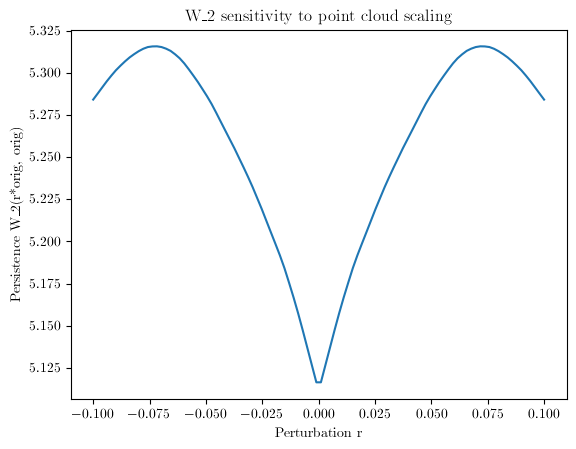

In [73]:
plt.plot(transform_array, scale_array)
plt.xlabel('Perturbation r')
plt.ylabel('Persistence W_2(r*orig, orig)')
plt.title('W_2 sensitivity to point cloud scaling')

Text(0.5, 1.0, 'Persistence W_2 sensitivity to point cloud shifting')

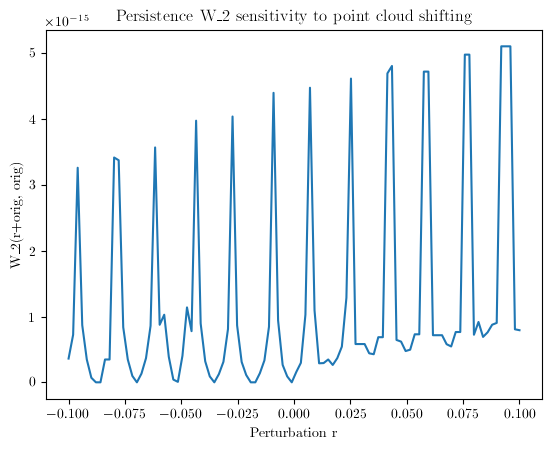

In [74]:
plt.plot(transform_array, shift_array)
plt.xlabel('Perturbation r')
plt.ylabel('W_2(r+orig, orig)')
plt.title('Persistence W_2 sensitivity to point cloud shifting')

Text(0.5, 1.0, 'Persistence W_2 sensitivity to point cloud shifting')

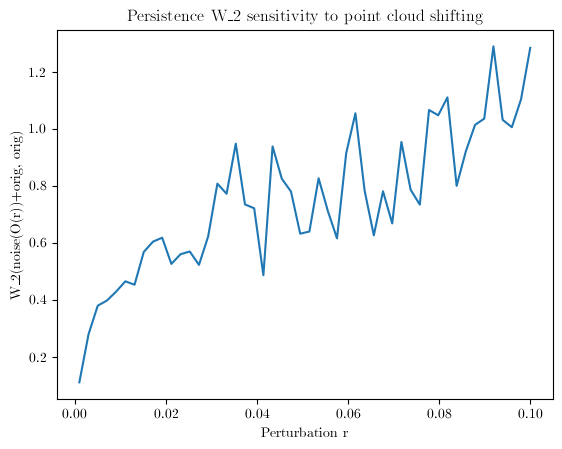

In [75]:
plt.plot([e for e in transform_array if e > 0], gauss_array)
plt.xlabel('Perturbation r')
plt.ylabel('W_2(noise(O(r))+orig, orig)')
plt.title('Persistence W_2 sensitivity to point cloud shifting')